# 1. Load Library

In [ ]:
from pathlib import Path 
from PIL import Image

import tensorflow as tf
import numpy as np


# 2. Basic Code from solution

In [ ]:
def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))


def log2n(n):
    if n > 1:
        exp_n = 1 + log2n(n / 2)
    else:
        exp_n = 0

    return exp_n 


# 3. Define my own function 

In [27]:
def main(tfpath: str, imgpath: str, height: int=512, width: int=512):
  """ function used to crop the image

  Args:

    tfpath: file path used to store tfrecords
    imgpath: file path used to store imges 
    height: image size for croping 
    width: image size for croping 

  """ 
  # read image 
  img = Image.open(imgpath)
  H, W = img.size
  img_name = Path(imgpath).stem 
  img_level = log2n(height)

  # create tfrecord
  (tfpath/img_name).mkdir(exist_ok=True)
  record_path = Path(tfpath)/ img_name/ f'{img_name}_L{img_level}.tfrecords'
  tf_writer = tf.io.TFRecordWriter(str(record_path))

  # crop image 
  num = 1
  for row in range(0, H, height): 
    for col in range(0, W, width): 
      # crop image 
      box = (col, row, col+width, row+height)
      patch = img.crop(box)
      patch = patch.tobytes() 
      patch_name, patch_format = f'{img_name}_patch{num}', 'png'
      # store image as tfrecord
      feature = {'height': _int64_feature(height),
            'width': _int64_feature(width),
            'depth': _int64_feature(3),
            'image/format': _bytes_feature(patch_format.encode('utf8')),
            'image_name': _bytes_feature(str(patch_name).encode('utf8')),
            'image/encoded': _bytes_feature(patch)}

      Example = tf.train.Example(features=tf.train.Features(feature=feature))
      Serialized = Example.SerializeToString()

      tf_writer.write(Serialized)
      num +=1
  tf_writer.close()

# 4. Test function

In [ ]:
tf_dir = Path('/content/tf')
img_dir = Path('/content/Image_Data')
imgs = ['b007.tif', 'is006.tif',  'iv017.tif', 'n050.tif']


In [ ]:
for img in imgs:
  main(tf_dir, img_dir/img)

# 5. Copy function to check Tfrecords 

In [ ]:
def get_data_from_tf(tf_path):
    feature = {'height': tf.io.FixedLenFeature([], tf.int64),
               'width': tf.io.FixedLenFeature([], tf.int64),
               'depth': tf.io.FixedLenFeature([], tf.int64),
               'image/format': tf.io.FixedLenFeature([], tf.string),
               'image_name': tf.io.FixedLenFeature([], tf.string),
               'image/encoded': tf.io.FixedLenFeature([], tf.string)}

    tfrecord_dataset = tf.data.TFRecordDataset(tf_path)

    def _parse_image_function(key):
        return tf.io.parse_single_example(key, feature)

    img_dataset = tfrecord_dataset.map(_parse_image_function)

    images = list()
    image_names = list()
    image_formats = list()
    image_height = list()
    image_width = list()
    image_depth = list()

    for tfrecord_value in img_dataset:
        height = tfrecord_value['height']
        width = tfrecord_value['width']
        depth = tfrecord_value['depth']
        format = tfrecord_value['image/format']
        name = tfrecord_value['image_name']
        img = tfrecord_value['image/encoded']

        images.append(img)
        image_names.append(name)
        image_formats.append(format)
        image_height.append(height)
        image_width.append(width)
        image_depth.append(depth)

    return images, image_names, image_formats, image_height, image_width, image_depth

def check_img_patch(patch_list):
  img_patches = list()
  for i in patch_list:
    img_patch = Image.frombytes('RGB', (512, 512), i.numpy())
    img_patches.append(img_patch)

  return img_patches

In [ ]:
b7_tf='/content/tf/b007/b007_L9.tfrecords'
is6_tf='/content/tf/is006/is006_L9.tfrecords'
iv17_tf='/content/tf/iv017/iv017_L9.tfrecords'
n50_tf='/content/tf/n050/n050_L9.tfrecords'

In [ ]:
images,image_names,image_formats, image_height, image_width, image_depth = get_data_from_tf(tf_path=n50_tf)

In [ ]:
image_patches = check_img_patch(images)

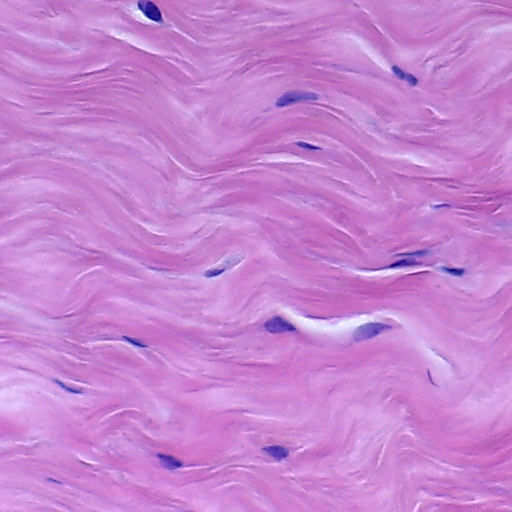

In [ ]:
image_patches[-5]

In [ ]:
image_names

[<tf.Tensor: shape=(), dtype=string, numpy=b'n050_patch1'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'n050_patch2'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'n050_patch3'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'n050_patch4'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'n050_patch5'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'n050_patch6'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'n050_patch7'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'n050_patch8'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'n050_patch9'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'n050_patch10'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'n050_patch11'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'n050_patch12'>]